# setup

In [1]:
from torch.utils.data import DataLoader
import json
import numpy as np
import base64
import zlib
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import zlib, base64
from skimage.io import imread
import os
import re
import sys
import cv2 as cv
import torch
import itertools

ojas_functions_dir = '/Users/ojas/Desktop/saj/SANDIA/pvcracks/retrain/'
sys.path.append(ojas_functions_dir)
import functions

In [ ]:
root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Fresh_LBNL/"
new_root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Channeled_ASU/"

img_folder = root + 'img/original/'
mask_folder = root + 'ann_json/'
image_file_extension = "jpg"

category_mapping = {0: "empty", 1: "dark", 2: "busbar", 3: "crack", 4: "non-cell"}
categories_list = list(category_mapping.values())

In [ ]:
files = [c for c in os.listdir(mask_folder)]

regex_string = r'(.+)\.' + image_file_extension + r'\.json'

n_masks = [re.search(regex_string, f).group(1) for f in files]

-----

# conversion code

In [13]:
def convert_json_to_multihot(json_file_path, image):
    """
    Converts a JSON mask file into a multi-hot encoded NumPy array file.
    
    Parameters:
      json_file_path: Path to the JSON file containing the annotations.
      output_file_path: Path to save the resulting .npy multi-hot encoded mask.
      mapping: A dict mapping classTitle strings (from JSON) to channel indices.
    
    The resulting NumPy array will have shape (5, height, width) where each channel
    corresponds to one class in your segmentation task.
    """
    # Load JSON data
    with open(json_file_path, 'r') as f:
        data = json.load(f)
    
    # Get image dimensions from the JSON
    height = data["size"]["height"]
    width = data["size"]["width"]
    
    # Create an empty multi-hot mask with 5 channels.
    # Channels: 0 = empty, 1 = dark, 2 = busbar, 3 = crack, 4 = non-cell.
    multi_hot = np.zeros((5, height, width), dtype=np.uint8)
    
    try:
        objects = data["objects"]
    except KeyError:
        objects = data["annotation"]["objects"]
        
    for obj in objects:
        if obj["geometryType"] == "bitmap":
            code = obj["bitmap"]["data"]
            origin = obj["bitmap"]["origin"]

            z = zlib.decompress(base64.b64decode(code))
            n = np.frombuffer(z, np.uint8)
            mask = cv.imdecode(n, cv.IMREAD_UNCHANGED)[:, :, 3].astype(bool)

            # This is some unfortunate maneuvering to address the fact that
            # bitmap annotations do not usually come in the same size as the
            # image from which they were labeled, and so it is necessary to
            # situate the annotation in an otherwise empty array that is the
            # same size as the image

            mask_center = np.array([mask.shape[1] / 2, mask.shape[0] / 2])
            mask_center += origin
            up = np.zeros((origin[1], mask.shape[1]))
            mask2 = np.vstack((up, mask))
            left = np.zeros((mask2.shape[0], origin[0]))
            mask3 = np.hstack((left, mask2))
            down = np.zeros((image.shape[0] - mask3.shape[0], mask3.shape[1]))
            mask4 = np.vstack((mask3, down))
            right = np.zeros((mask4.shape[0], image.shape[1] - mask4.shape[1]))
            mask5 = np.hstack((mask4, right)).astype(bool)
            
        elif obj["geometryType"] == "rectangle":
            # Handle rectangle masks
            points = obj["points"]["exterior"]
            x1, y1 = points[0]
            x2, y2 = points[1]
            
            mask5 = np.zeros(image.shape[:-1]).astype(bool)
            mask5[y1:y2, x1:x2] = True   
        
        for idx, category in enumerate(categories_list):
            if category in obj["classTitle"].lower():
                # print(f"Adding mask for category: {category} at idx {idx}")
                # [print(f"Multi-hot at idx 4 before logical or: {multi_hot[idx]}") if idx == 4 else None]
                multi_hot[idx] = np.logical_or(
                    multi_hot[idx], mask5
                ).astype(bool)
                # [print(f"Multi-hot at idx 4 after logical or: {multi_hot[idx]}") if idx == 4 else None]
    
    
    return multi_hot

---

## viz stuff

In [6]:
def stack_masks(
    multihot, image, order=[4, 3, 2, 1, 0], mapping={0: 1, 1: 2, 2: 3, 3: 4, 4: 5}
):

    # Stack the four n_x by n_y feature arrays
    all_masks = torch.dstack([torch.tensor(v) for v in multihot]).permute(
        2, 0, 1
    )

    new_tensor = torch.zeros(
        [all_masks.shape[1], all_masks.shape[2]], dtype=torch.float64
    )

    for i, j in itertools.product(range(image.shape[0]), range(image.shape[1])):

        if all_masks[order[0], i, j]:
            val = mapping[order[0]]
        elif all_masks[order[1], i, j]:
            val = mapping[order[1]]
        elif all_masks[order[2], i, j]:
            val = mapping[order[2]]
        elif all_masks[order[3], i, j]:
            val = mapping[order[3]]
        else:
            val = 0

        new_tensor[i, j] = val

    return new_tensor

In [ ]:
def plot_and_show_labels(cracks_mask):
    fig, ax = plt.subplots()

    clim = (0, 5)
    ax.imshow(cracks_mask, clim=clim, interpolation='None')

    # Do legend
    cmap = mpl.colormaps['viridis'].resampled(5)  # define the colormap
    cmaplist = [cmap(i) for i in range(5)]
    handles, labels = ax.get_legend_handles_labels()
    
    for c, classlabel in zip(cmaplist, [f'({k}) {v}' for k, v in category_mapping.items()]):
            patch = mpatches.Patch(color=c, label=classlabel, ec='k')
            handles.append(patch)
    ax.legend(handles=handles, fontsize='x-small')

    ax.axis('off')

In [ ]:
def inference_and_show(img, gt_mask):
    fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(10, 10), layout='compressed')

    ax[0, 0].imshow(img, cmap='gray', interpolation='None')
    ax[0, 0].axis('off')
    ax[0, 0].set_title('(a) EL image', fontsize='xx-large')
    ##
    for i in range(5):
        ax[1, i].imshow(gt_mask[i], cmap='viridis', interpolation='None')
        ax[1, i].axis('off')
        ax[1, i].set_title(f'({i}) {category_mapping[i]} activation')

------

# Converting all masks

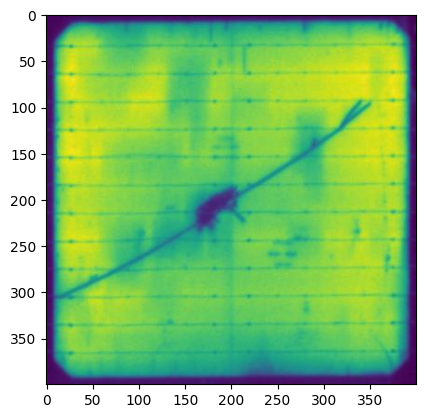

In [ ]:
for n in n_masks:
    mask_path = os.path.join(mask_folder, f'{n}.{image_file_extension}.json')
    img_path = os.path.join(img_folder, f'{n}.{image_file_extension}')

    image = imread(img_path)

    multihot = convert_json_to_multihot(mask_path, image)

    plt.imshow(image)
    
    output_file_path = new_root + "ann/channeled/" + f"{n}.npy"
    np.save(output_file_path, multihot)

In [ ]:
stacked = stack_masks(multihot, image)

plot_and_show_labels(stacked)

---

after rotation and flipping, ensure that all channels of masks were rotated too


['my_1_EL_18.09.2023-15-40-40_unknownID_ASU Minisample_SHJ5_103', 'mx_1_EL_18.09.2023-15-40-40_unknownID_ASU Minisample_SHJ5_103', 'mxy_1_EL_18.09.2023-15-40-40_unknownID_ASU Minisample_SHJ5_103', 'my_1240 - NICE_SHJ_2_Isc (EL Image)', 'mx_1240 - NICE_SHJ_2_Isc (EL Image)', 'mxy_1240 - NICE_SHJ_2_Isc (EL Image)', 'my_1220 - Old TC for PID_2_rear_Isc (EL Image)', 'mx_1220 - Old TC for PID_2_rear_Isc (EL Image)', 'mxy_1220 - Old TC for PID_2_rear_Isc (EL Image)', 'my_3_EL_18.09.2023-15-43-19_unknownID_ASU Minisample_SHJ6_106', 'mx_3_EL_18.09.2023-15-43-19_unknownID_ASU Minisample_SHJ6_106', 'mxy_3_EL_18.09.2023-15-43-19_unknownID_ASU Minisample_SHJ6_106', 'my_2_EL_2x2_NQ-03_20230915_125152', 'mx_2_EL_2x2_NQ-03_20230915_125152', 'mxy_2_EL_2x2_NQ-03_20230915_125152', 'my_3_EL_2x2_NQ-01_20230915_125923', 'mx_3_EL_2x2_NQ-01_20230915_125923', 'mxy_3_EL_2x2_NQ-01_20230915_125923', 'my_1155 - Ea_SHJ_POE_5_Isc (EL Image)', 'mx_1155 - Ea_SHJ_POE_5_Isc (EL Image)', 'mxy_1155 - Ea_SHJ_POE_5_Isc (EL

/var/folders/_l/7n7n98ws5fx8zfcbxfmfs7fh0000gn/T/ipykernel_78480/78857164.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(10, 10), layout='compressed')


/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Channeled_ASU/ann/train/my_3_EL_18.09.2023-14-55-55_unknownID_ASU Minisample_06_62.npy
/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Channeled_ASU/img/train/my_3_EL_18.09.2023-14-55-55_unknownID_ASU Minisample_06_62.jpg


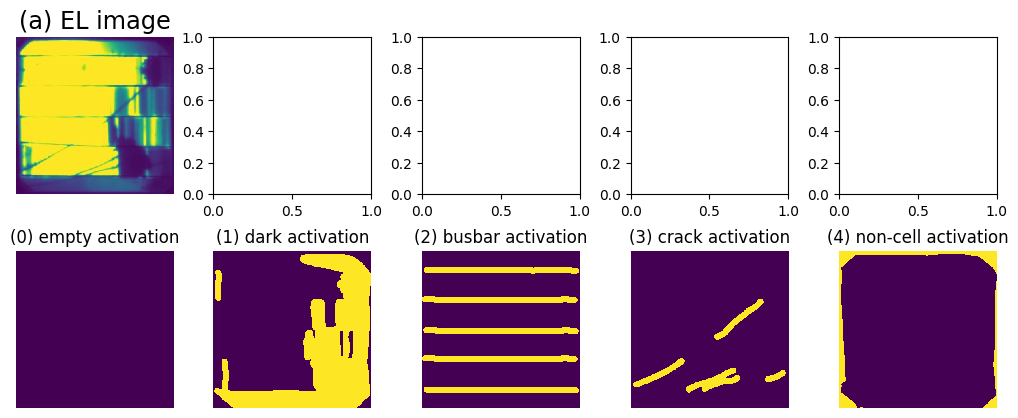

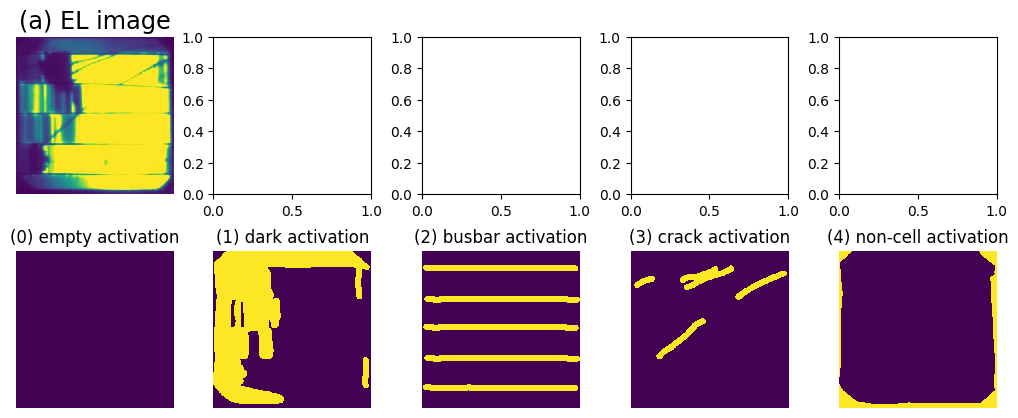

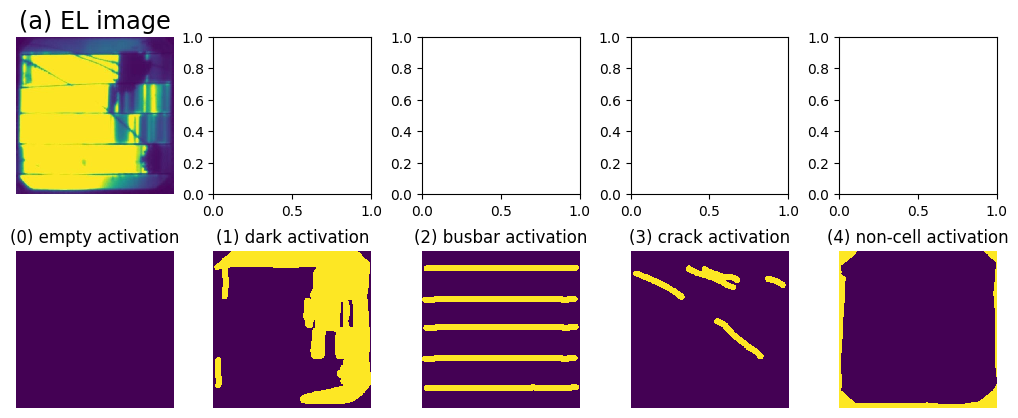

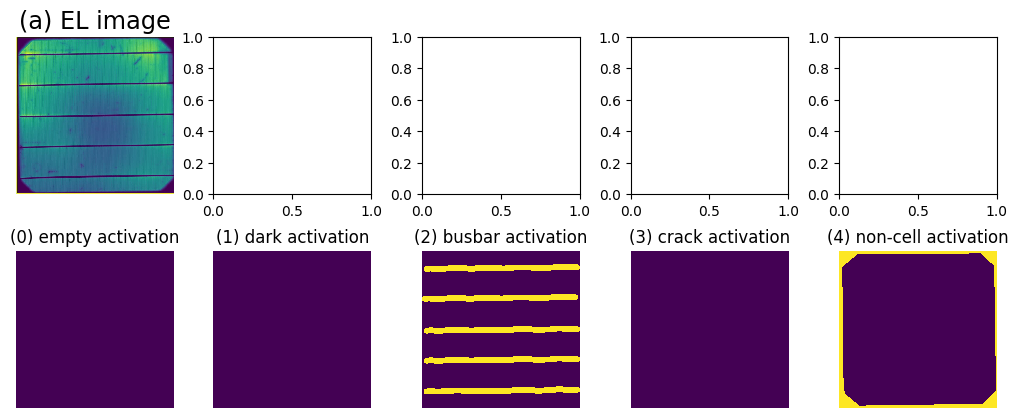

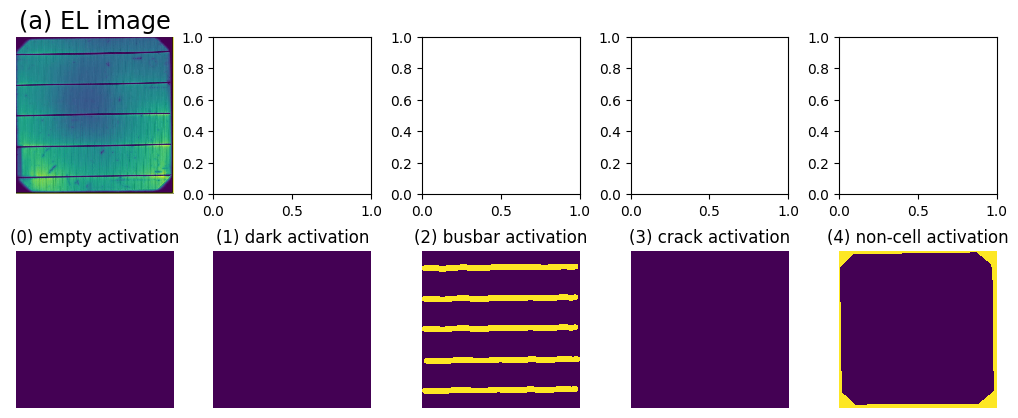

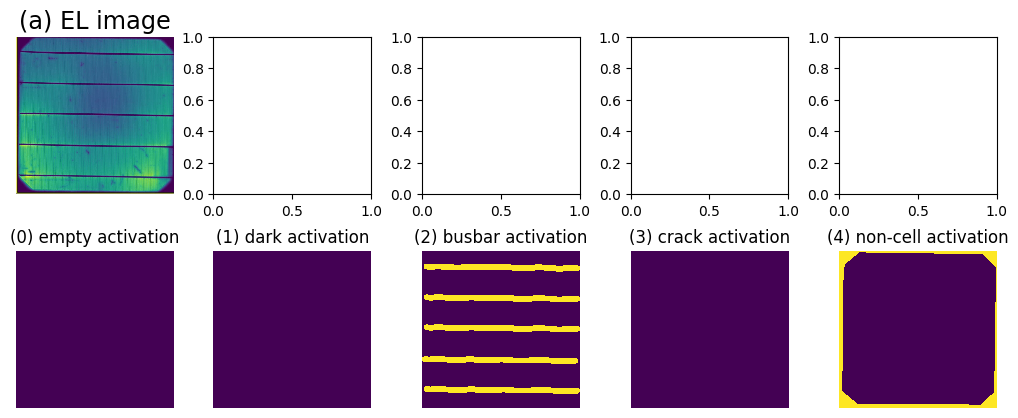

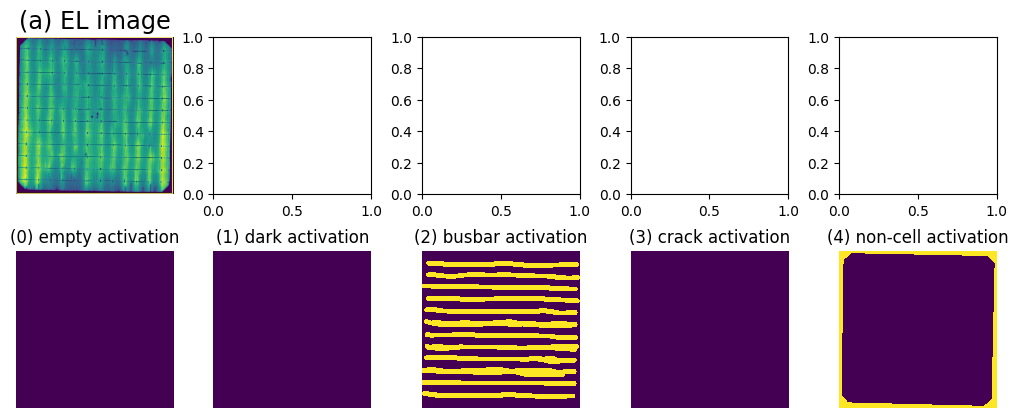

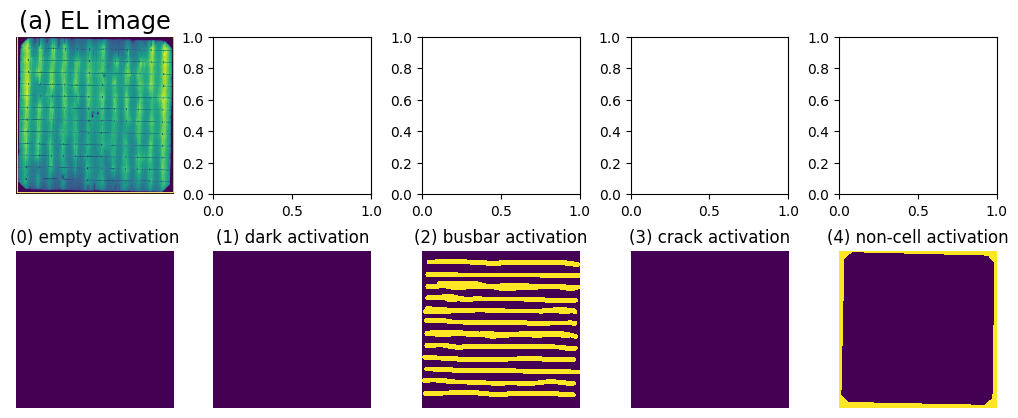

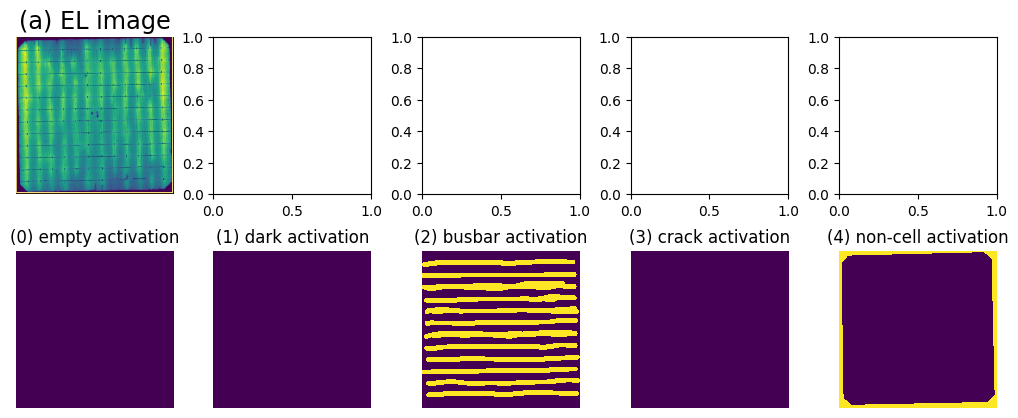

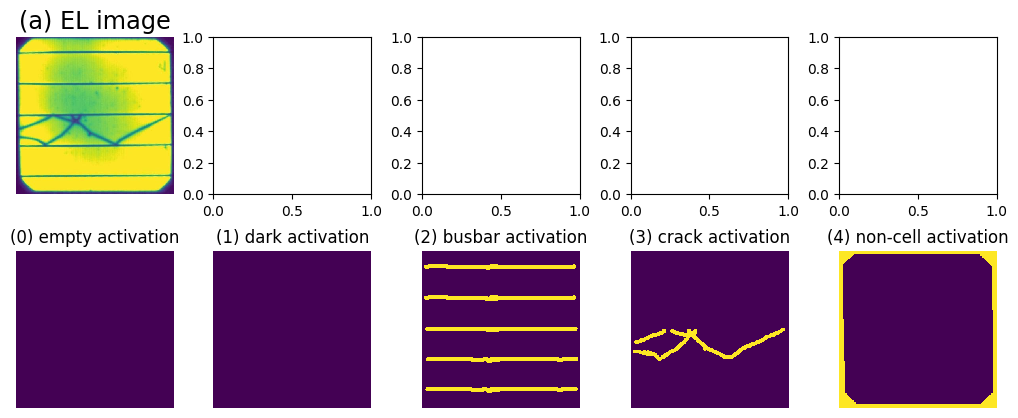

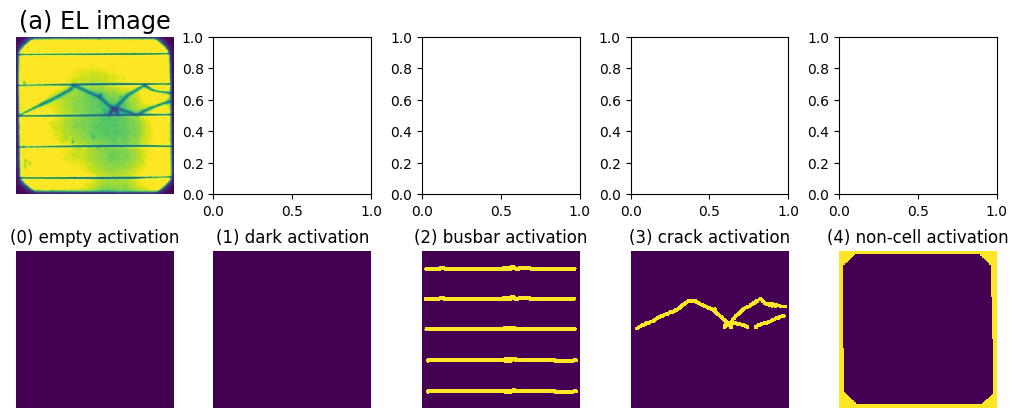

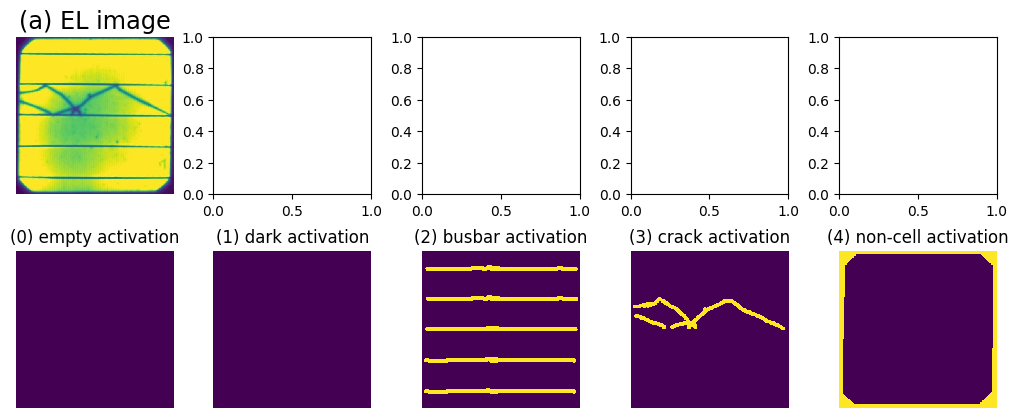

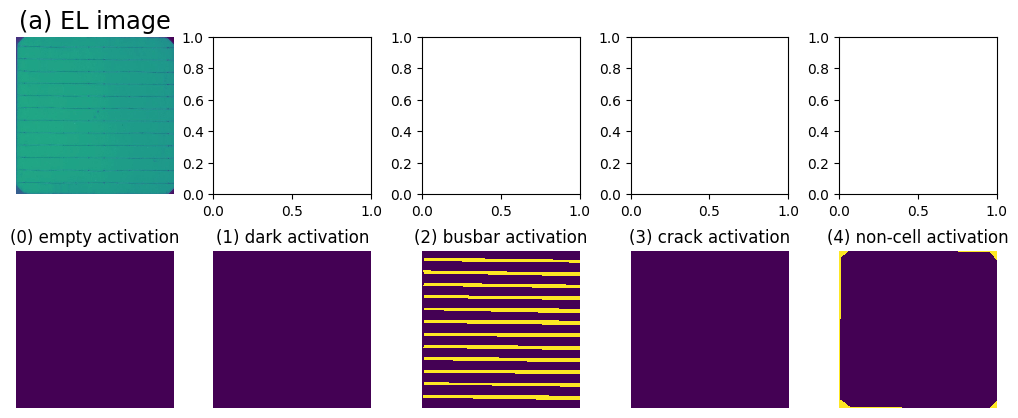

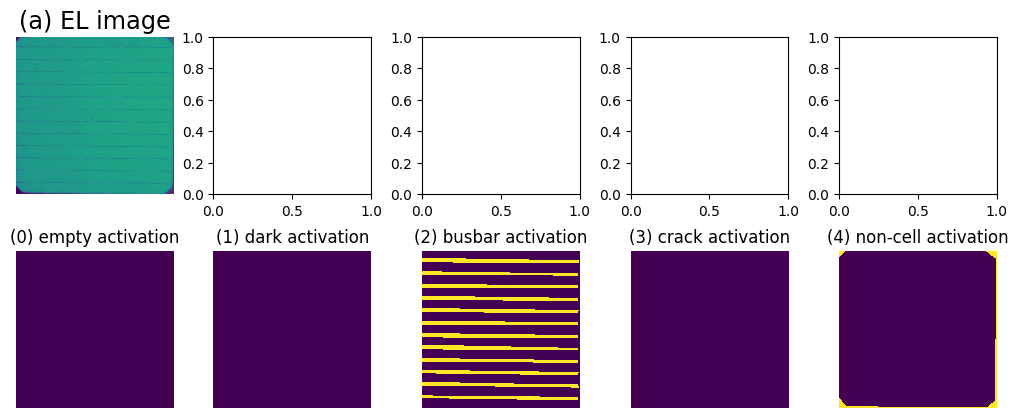

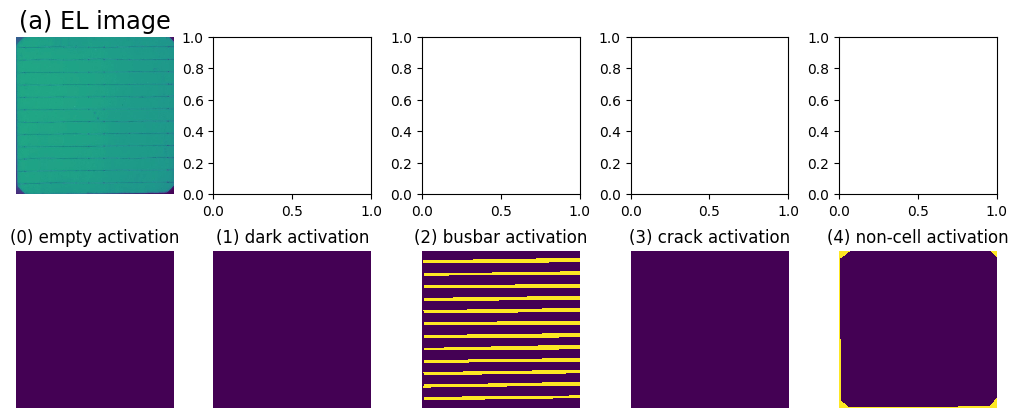

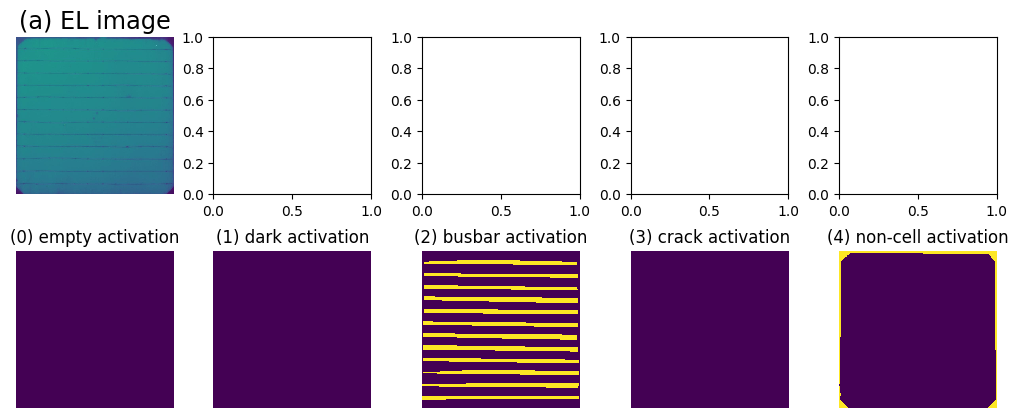

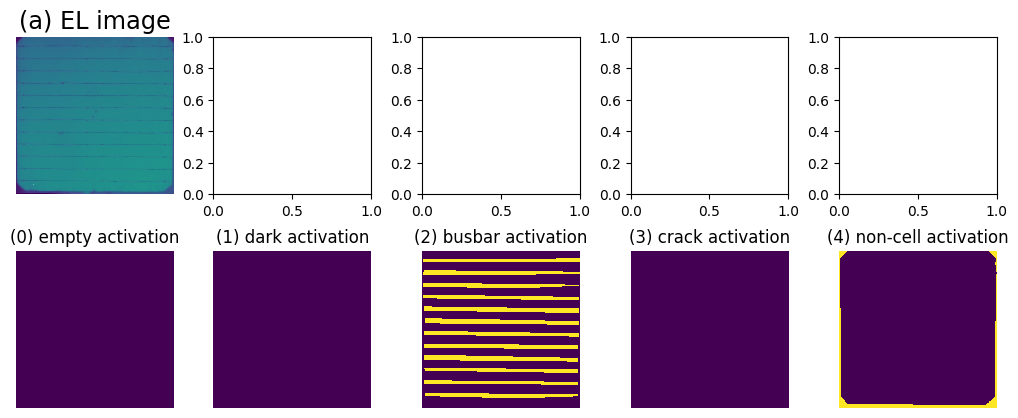

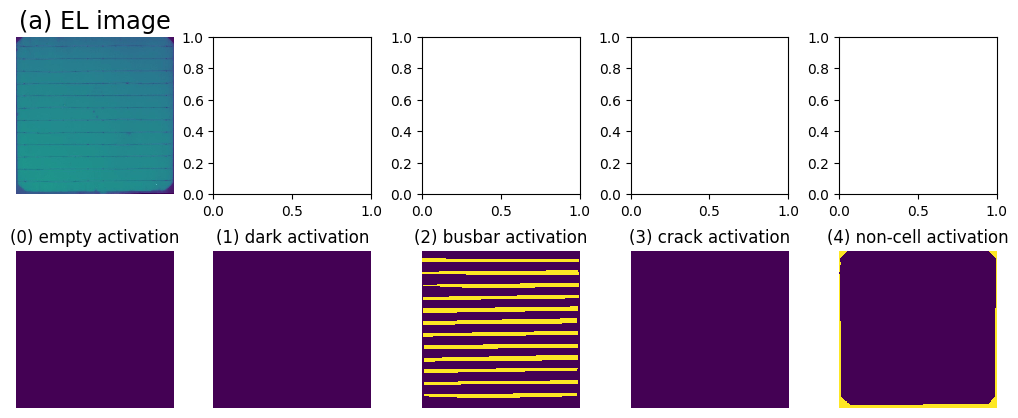

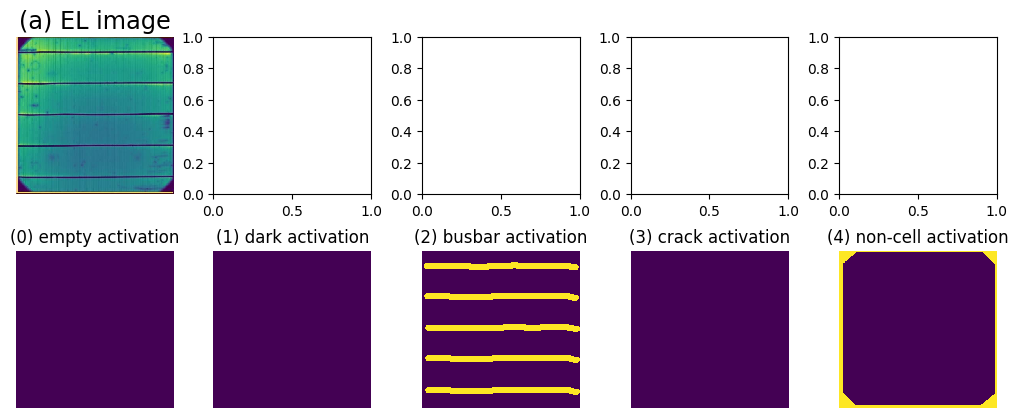

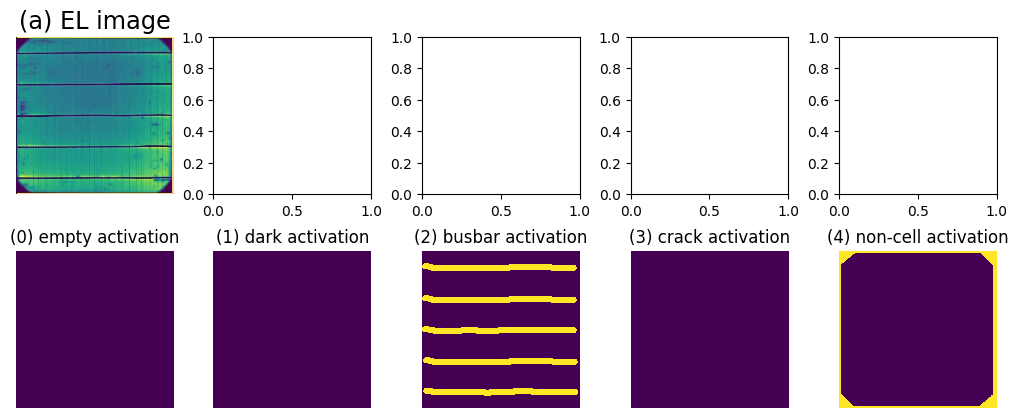

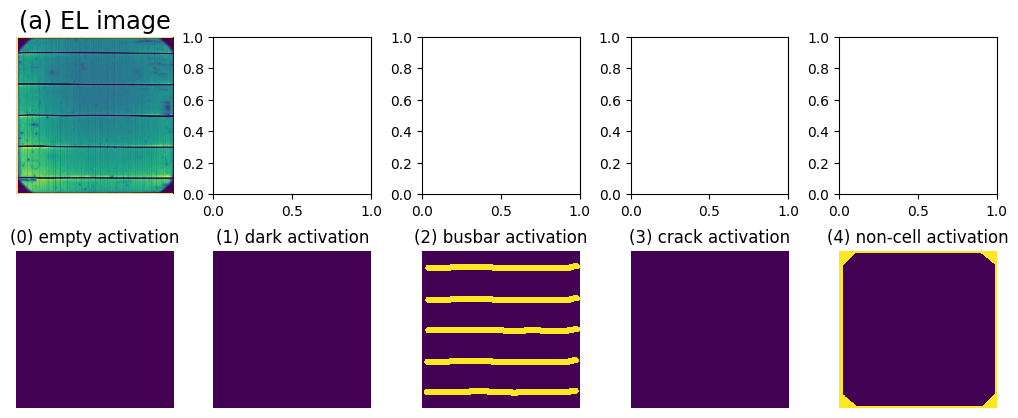

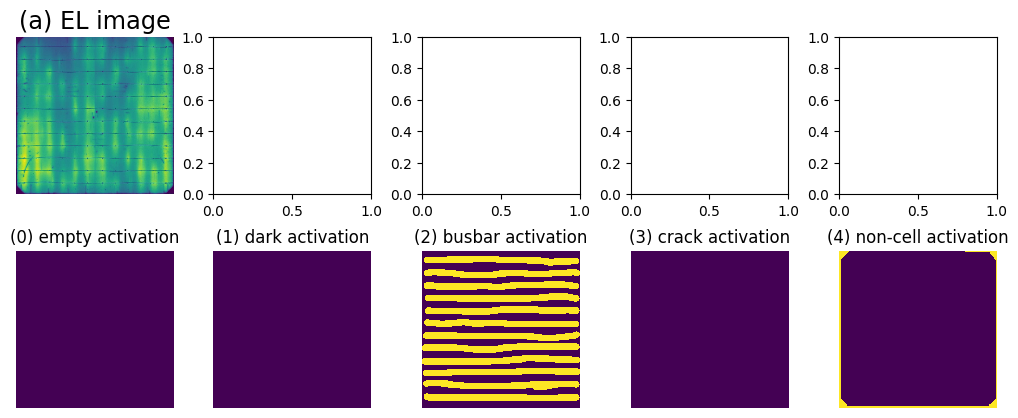

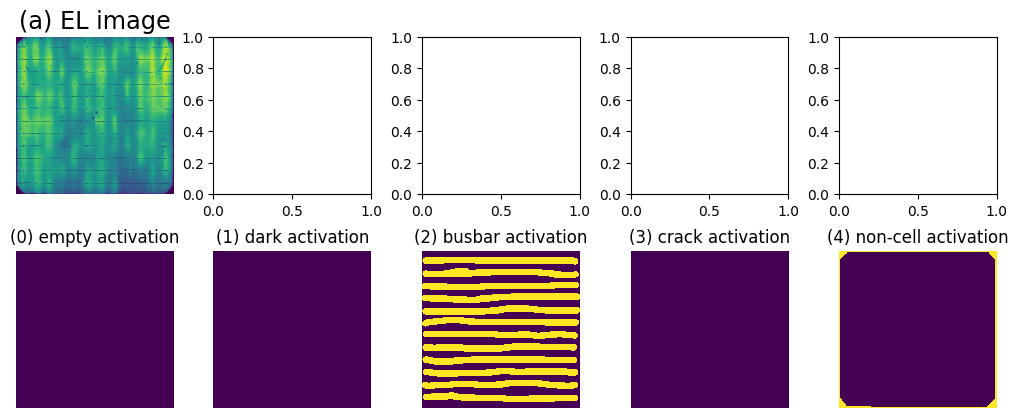

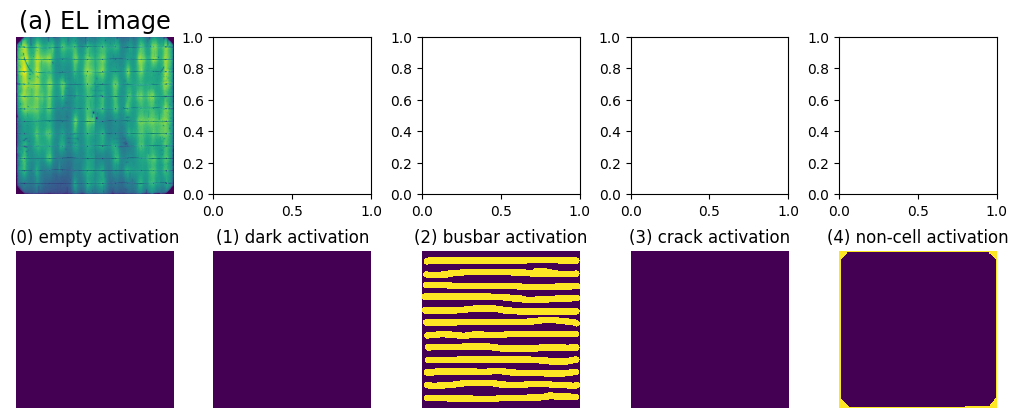

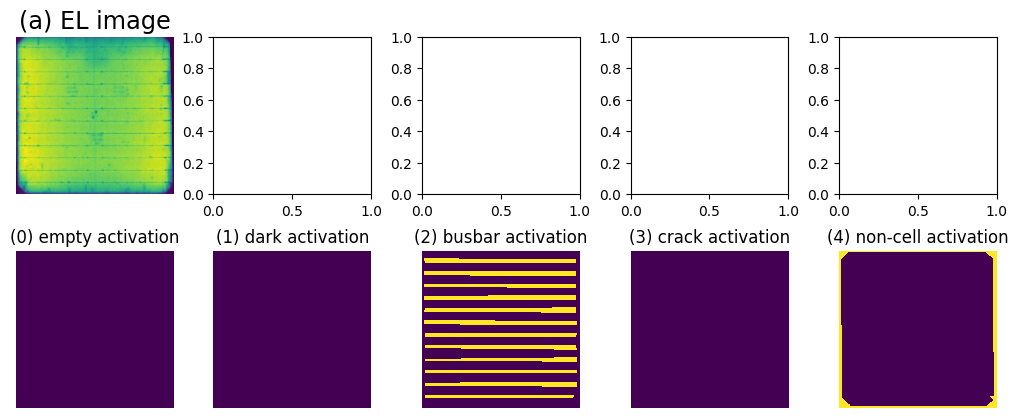

In [ ]:
root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Fresh_ASU/"
new_root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Channeled_ASU/"

img_folder = new_root + 'img/train/'
mask_folder = new_root + 'ann/train/'
image_file_extension = "jpg"

files = [c for c in os.listdir(mask_folder)]

npy_regex_string = r"^(.*?)(?=\.npy)"

n_masks = [re.search(npy_regex_string, f).group(1) for f in files]

raw_mask_names = []
custom_mask_list = []

for mask_name in n_masks:
    if not mask_name.startswith("m"):
        raw_mask_names.append(mask_name)

for raw_mask_name in raw_mask_names:
    for additive in ["my_", "mx_", "mxy_"]:
        custom_mask_name = f"{additive}{raw_mask_name}"
        custom_mask_list.append(custom_mask_name)

print(custom_mask_list[:25])

for n in custom_mask_list[0:25]:
    # mask_path = os.path.join(mask_folder, f'{n}.{image_file_extension}.json')
    mask_path = os.path.join(mask_folder, f'{n}.npy')
    img_path = os.path.join(img_folder, f'{n}.jpg')
    
    print(mask_path)
    print(img_path)

    image = imread(img_path)
    loaded_mask = np.load(mask_path, allow_pickle=True)

    # multihot = convert_json_to_multihot(mask_path, image)
    inference_and_show(image, loaded_mask)